<a href="https://colab.research.google.com/github/bubriks/ID2223/blob/main/Project/project-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Course Project: Scalable Machine Learning and Deep Learning**

## **Paolo Teta & Ralfs Zangis**
---

# **Requirements**

**Tensorflow**

In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K

**Other**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Mount Google Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
# **1. Get the data**

**Link:** https://drive.google.com/file/d/1Du-gZz1LU-StWbahzckG1EmSLC-FuW5S/view?usp=sharing

In [87]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset-project.csv")
df["pixels"] = [[int(y) for y in x.split(" ")] for x in df["pixels"]]

---
# **2. Explore the data**

In [88]:
print(df)

       emotion                                             pixels        usage
0            0  [70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...     Training
1            0  [151, 150, 147, 155, 148, 133, 111, 140, 170, ...     Training
2            2  [231, 212, 156, 164, 174, 138, 161, 173, 182, ...     Training
3            4  [24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...     Training
4            6  [4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...     Training
...        ...                                                ...          ...
35882        6  [50, 36, 17, 22, 23, 29, 33, 39, 34, 37, 37, 3...  PrivateTest
35883        3  [178, 174, 172, 173, 181, 188, 191, 194, 196, ...  PrivateTest
35884        0  [17, 17, 16, 23, 28, 22, 19, 17, 25, 26, 20, 2...  PrivateTest
35885        3  [30, 28, 28, 29, 31, 30, 42, 68, 79, 81, 77, 6...  PrivateTest
35886        2  [19, 13, 14, 12, 13, 16, 21, 33, 50, 57, 71, 8...  PrivateTest

[35887 rows x 3 columns]


In [89]:
df.dtypes

emotion     int64
pixels     object
usage      object
dtype: object

In [90]:
print(df.count())

emotion    35887
pixels     35887
usage      35887
dtype: int64


In [91]:
print(df["usage"].unique())

['Training' 'PublicTest' 'PrivateTest']


In [92]:
print(df["emotion"].value_counts())

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


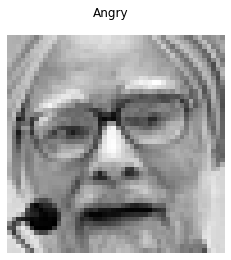

In [93]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

dataId = 1

row = df.iloc[dataId]
plt.figure(dataId)
pixelArray = np.asarray(row["pixels"])
plt.suptitle(emotion_labels[row["emotion"]])
plt.axis('off')
plt.imshow(pixelArray.reshape((48, 48)), interpolation='none', cmap='gray')

---
# **3. Prepare data**

Reshape pixels

In [94]:
df["pixels"] = [np.reshape(x, (1, 48, 48)) for x in df["pixels"]]

Separate dataset

In [95]:
train_df = df[df["usage"] == "Training"]
val_df = df[df["usage"] == "PublicTest"]
test_df = df[df["usage"] == "PrivateTest"]
df = None #to save memory

---
# **4. Make model**

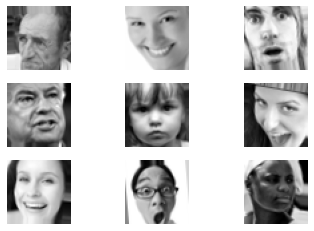

In [110]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

x = np.array(train_df['pixels'].tolist())
y = np.array(train_df['emotion'])

datagen.fit(x)

train_flow = datagen.flow(x, y, batch_size=9)

for X_batch, y_batch in train_flow:
    for i in range(0, 9):
        plt.axis('off')
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()
    break

In [101]:
K.set_image_data_format('channels_first')

def swish_activation(x):
    return (K.sigmoid(x) * x)

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(1,48,48)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(tf.keras.layers.Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation=swish_activation))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(7 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam' ,
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 48, 48)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 48, 48)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 24, 24)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 24, 24)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 24, 24)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 12, 12)       0         
 2D)                                                    

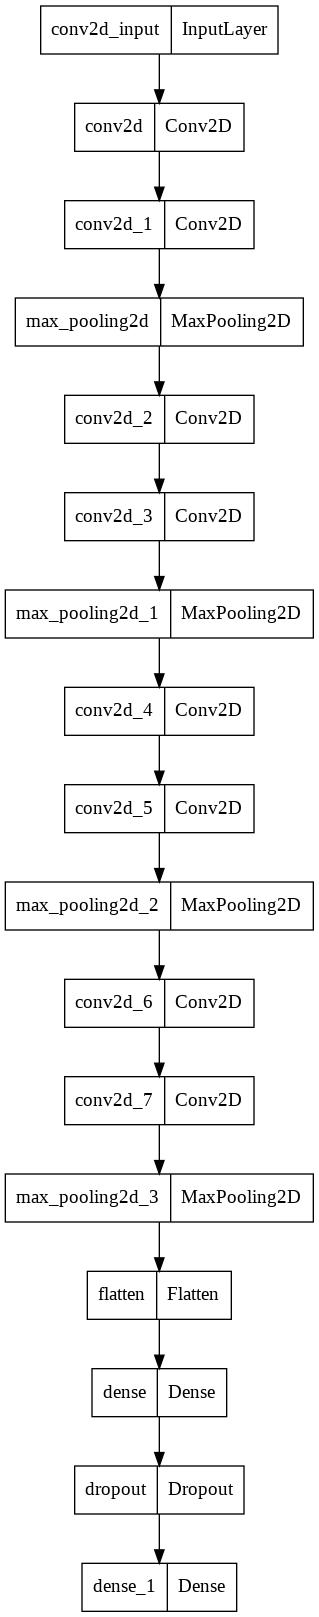

In [102]:
tf.keras.utils.plot_model(model)

---
# **5. Train model**

In [103]:
model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])

In [100]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

In [111]:
batch_size = 128
epochs = 14

x = np.array(train_df['pixels'].tolist())
y = np.array(train_df['emotion'])

x_1 = np.array(val_df['pixels'].tolist())
y_1 = np.array(val_df['emotion'])

history = model.fit_generator(
    train_flow,
    callbacks=[lr_reduce],
    validation_data=(x_1, y_1),
    epochs = epochs,
    verbose = 2)

Epoch 1/14


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  from ipykernel import kernelapp as app


ValueError: ignored

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

---
# **6. Prediction**

In [ ]:
%matplotlib notebook

import cv2
import matplotlib.pyplot as plt
import signal

In [ ]:
def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

In [ ]:
vc = cv2.VideoCapture(0)

plt.ion()

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview = plt.imshow(frame)    
else:
    is_capturing = False

signal.signal(signal.SIGINT, signal_handler)
is_interrupted = False
while is_capturing:
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview.set_data(frame)
    plt.draw()

    try:    # Avoids a NotImplementedError caused by `plt.pause`
        plt.pause(0.05)
    except Exception:
        pass
    if is_interrupted:
        vc.release()
        break